In [97]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, KFold
import seaborn as sns
from scipy.stats import pearsonr

# =============================================================================
# STEP 0: Load Rentals Data
# =============================================================================

In [98]:
df_rentals_initial = pd.read_csv("../data/paris_rentals.csv", 
                                 delimiter=';', 
                                 on_bad_lines='skip', 
                                 encoding='utf-8')

# =============================================================================
# STEP 1: Get Neighborhood Geometries
# =============================================================================

In [99]:
use_fine_grid = True

In [100]:
if use_fine_grid:
    # Extract fine-grid neighborhoods from rentals data
    df_neigh = df_rentals_initial.drop_duplicates(subset="Numéro du quartier")
    df_neigh = df_neigh[["Numéro du quartier", "geo_shape"]]
    print(f"Number of unique neighborhoods (fine grid): {len(df_neigh)}")
    
    # Rename and convert the GeoJSON geometry to Shapely objects
    df_neigh.rename(columns={"Numéro du quartier": "neigh_id"}, inplace=True)
    
    def convert_geojson(geo_str):
        try:
            geo_dict = json.loads(geo_str)
            return shape(geo_dict)
        except Exception as e:
            print("Error converting geometry:", e)
            return None

    df_neigh["geometry"] = df_neigh["geo_shape"].apply(convert_geojson)
    gdf_neigh = gpd.GeoDataFrame(df_neigh, geometry="geometry", crs="EPSG:4326")
else:
    # Load neighborhoods from a GeoJSON file
    gdf_neigh = gpd.read_file("../data/neighbourhoods.geojson")
    gdf_neigh.rename(columns={"neighbourhood": "neigh_id"}, inplace=True)
    gdf_neigh = gdf_neigh.drop_duplicates(subset="neigh_id")
    gdf_neigh.set_crs("EPSG:4326", inplace=True)
    print(f"Number of unique neighborhoods (GeoJSON): {len(gdf_neigh)}")


Number of unique neighborhoods (fine grid): 80


# =============================================================================
# STEP 2: Load Airbnb Listings and Compute Airbnb Density
# =============================================================================

Original Airbnb data rows: 91031
Airbnb DataFrame shape: (91031, 18)
Airbnb columns: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'license']
Total number of Airbnb listings in Paris: 91031


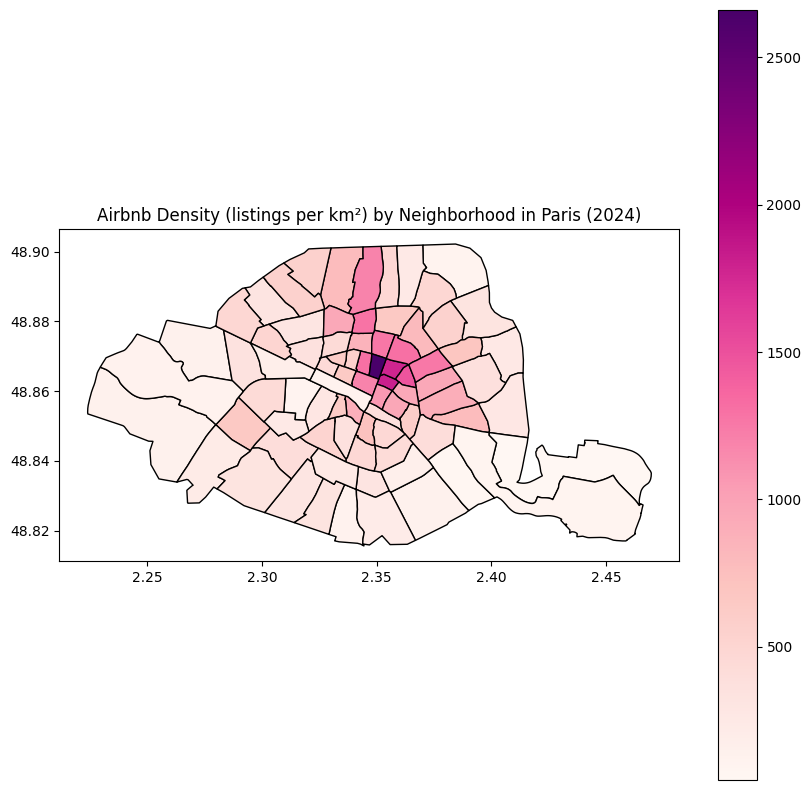

In [101]:
df_airbnb = pd.read_csv("../data/paris_airbnb.csv", 
                        delimiter=',', 
                        on_bad_lines='skip', 
                        encoding='utf-8')
print(f"Original Airbnb data rows: {len(df_airbnb)}")
print("Airbnb DataFrame shape:", df_airbnb.shape)
print("Airbnb columns:", list(df_airbnb.columns))

# Create point geometry from latitude (col index 6) and longitude (col index 7)
def create_point(row):
    if len(row) >= 8:
        try:
            lon, lat = row.iloc[7], row.iloc[6]
            return Point(lon, lat)
        except Exception as e:
            print("Error creating point for row:", e)
            return None
    else:
        return None

df_airbnb['geometry'] = df_airbnb.apply(create_point, axis=1)
df_airbnb = df_airbnb[df_airbnb['geometry'].notnull()]
gdf_airbnb = gpd.GeoDataFrame(df_airbnb, geometry='geometry', crs="EPSG:4326")

# Spatial join: assign Airbnb listings to neighborhoods
gdf_airbnb_joined = gpd.sjoin(gdf_airbnb, gdf_neigh, how='left', predicate='within')
airbnb_counts = gdf_airbnb_joined.groupby('neigh_id').size().reset_index(name='airbnb_count')
gdf_neigh = gdf_neigh.merge(airbnb_counts, on='neigh_id', how='left')
gdf_neigh['airbnb_count'] = gdf_neigh['airbnb_count'].fillna(0).astype(int)

# Compute area in km² (project to EPSG:3857) and calculate density
gdf_neigh['area_km2'] = gdf_neigh.to_crs(epsg=3857).area / 1e6
gdf_neigh['airbnb_density'] = gdf_neigh['airbnb_count'] / gdf_neigh['area_km2']
print(f"Total number of Airbnb listings in Paris: {len(gdf_airbnb)}")

# Plot Airbnb density map
fig, ax = plt.subplots(figsize=(10, 10))
gdf_neigh.plot(column='airbnb_density', cmap='RdPu', legend=True, ax=ax, edgecolor='black')
ax.set_title("Airbnb Density (listings per km²) by Neighborhood in Paris (2024)")
plt.show()

# =============================================================================
# STEP 3: Compute Average Rental Prices for 2024 and 2019, Then Price Increase
# =============================================================================

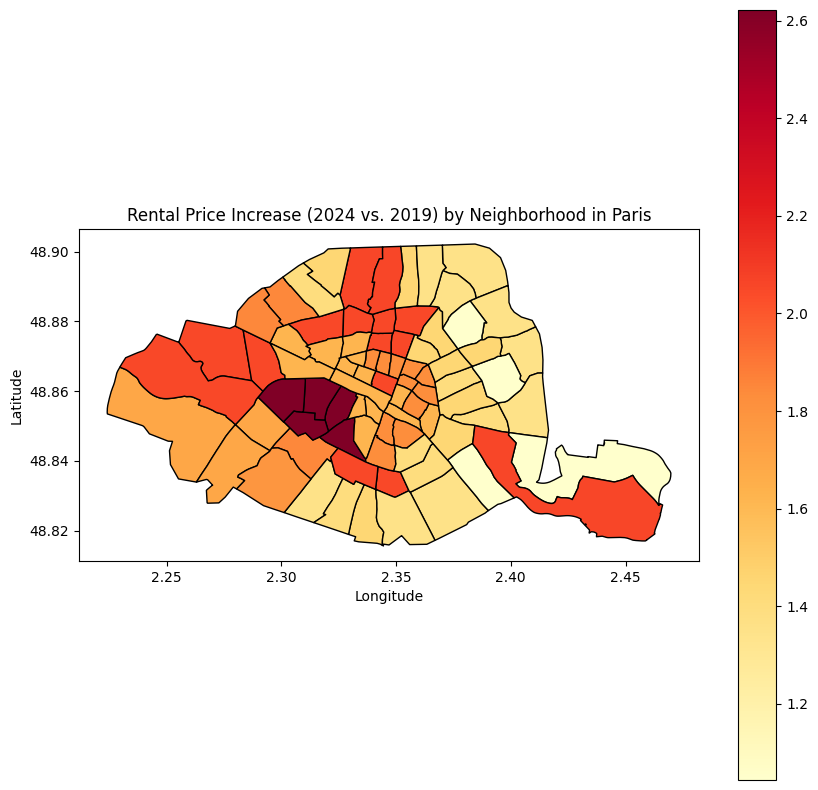

In [102]:
df_rentals_2024 = df_rentals_initial[df_rentals_initial.iloc[:, 0] == 2024].copy()
df_rentals_2019 = df_rentals_initial[df_rentals_initial.iloc[:, 0] == 2019].copy()

def parse_coords(coord_str):
    try:
        lat_str, lon_str = coord_str.split(',')
        lat = float(lat_str.strip())
        lon = float(lon_str.strip())
        return Point(lon, lat)
    except Exception as e:
        print("Error parsing coordinates:", e)
        return None

df_rentals_2024['geometry'] = df_rentals_2024.iloc[:, 13].apply(parse_coords)
df_rentals_2019['geometry'] = df_rentals_2019.iloc[:, 13].apply(parse_coords)

# Rental price is assumed to be in column index 7
df_rentals_2024['rental_price'] = pd.to_numeric(df_rentals_2024.iloc[:, 7], errors='coerce')
df_rentals_2019['rental_price'] = pd.to_numeric(df_rentals_2019.iloc[:, 7], errors='coerce')

df_rentals_2024 = df_rentals_2024[df_rentals_2024['geometry'].notnull() & df_rentals_2024['rental_price'].notnull()]
df_rentals_2019 = df_rentals_2019[df_rentals_2019['geometry'].notnull() & df_rentals_2019['rental_price'].notnull()]

gdf_rentals_2024 = gpd.GeoDataFrame(df_rentals_2024, geometry='geometry', crs="EPSG:4326")
gdf_rentals_2019 = gpd.GeoDataFrame(df_rentals_2019, geometry='geometry', crs="EPSG:4326")

# Spatial join rentals to neighborhoods
gdf_rentals_2024_joined = gpd.sjoin(gdf_rentals_2024, gdf_neigh, how='left', predicate='within')
gdf_rentals_2019_joined = gpd.sjoin(gdf_rentals_2019, gdf_neigh, how='left', predicate='within')

avg_prices_2024 = gdf_rentals_2024_joined.groupby('neigh_id')['rental_price'].mean().reset_index(name='avg_rental_price_2024')
gdf_neigh = gdf_neigh.merge(avg_prices_2024, on='neigh_id', how='left')
gdf_neigh['avg_rental_price_2024'] = gdf_neigh['avg_rental_price_2024'].fillna(0)

avg_prices_2019 = gdf_rentals_2019_joined.groupby('neigh_id')['rental_price'].mean().reset_index(name='avg_rental_price_2019')
gdf_neigh = gdf_neigh.merge(avg_prices_2019, on='neigh_id', how='left')
gdf_neigh['avg_rental_price_2019'] = gdf_neigh['avg_rental_price_2019'].fillna(0)

# Compute rental price increase (2024 - 2019)
gdf_neigh['price_increase'] = gdf_neigh['avg_rental_price_2024'] - gdf_neigh['avg_rental_price_2019']

# Plot rental price increase map
fig, ax = plt.subplots(figsize=(10, 10))
gdf_neigh.plot(column='price_increase', cmap='YlOrRd', legend=True, ax=ax, edgecolor='black')
ax.set_title("Rental Price Increase (2024 vs. 2019) by Neighborhood in Paris")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

# ============================================================================
# Step 4: Any visual intuition ?
# ============================================================================

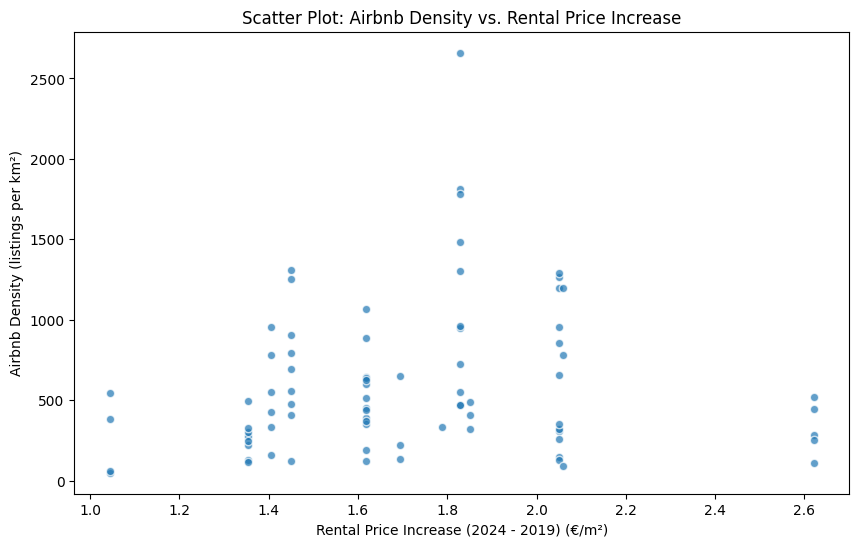

In [103]:
fig_scatter, ax_scatter = plt.subplots(figsize=(10, 6))
ax_scatter.scatter(gdf_neigh['price_increase'], gdf_neigh['airbnb_density'], 
                   alpha=0.7, edgecolors='w')
ax_scatter.set_xlabel("Rental Price Increase (2024 - 2019) (€/m²)")
ax_scatter.set_ylabel("Airbnb Density (listings per km²)")
ax_scatter.set_title("Scatter Plot: Airbnb Density vs. Rental Price Increase")
plt.show()

# =============================================================================
# STEP 4: Bias-Variance Analysis (Price Increase vs. Airbnb Density)
# =============================================================================

   degree      train_mse       test_mse
0       1  209862.656447  220447.592506
1       2  186797.391119  194262.343321
2       3  185442.429066  194714.486262
3       4  180762.044123  204406.952949
4       5  176063.954118  211172.469379


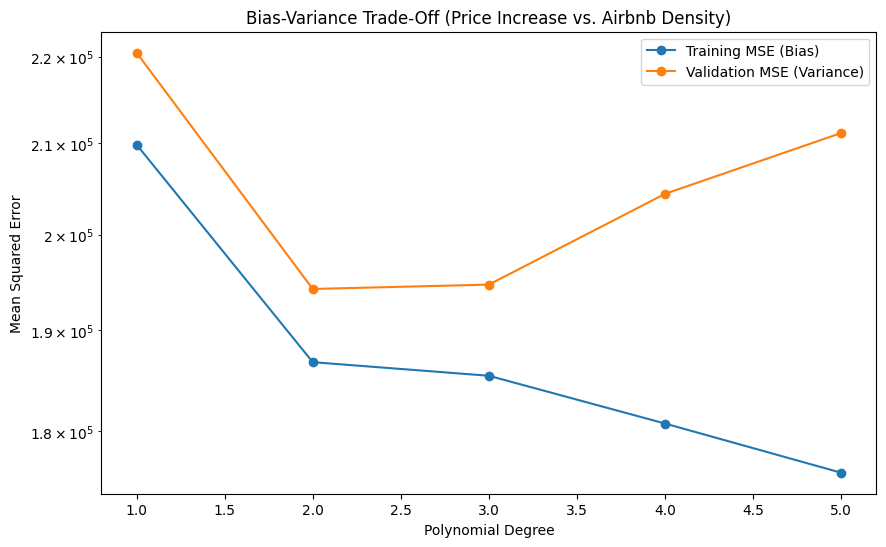

In [104]:
# Predictor: price_increase, Target: airbnb_density
X = gdf_neigh['price_increase'].values.reshape(-1, 1)
Y = gdf_neigh['airbnb_density'].values

degrees = range(1, 6)  # Test polynomial degrees 1 through 5
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results_list = []

for deg in degrees:
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly = poly.fit_transform(X)
    lr = LinearRegression()
    cv_results = cross_validate(lr, X_poly, Y, cv=kf, scoring='neg_mean_squared_error', return_train_score=True)
    train_mse = -np.mean(cv_results['train_score'])
    test_mse = -np.mean(cv_results['test_score'])
    cv_results_list.append({'degree': deg, 'train_mse': train_mse, 'test_mse': test_mse})

cv_results_df = pd.DataFrame(cv_results_list)
print(cv_results_df)

# Plot Bias-Variance Trade-Off curves
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cv_results_df['degree'], cv_results_df['train_mse'], marker='o', label='Training MSE (Bias)')
ax.plot(cv_results_df['degree'], cv_results_df['test_mse'], marker='o', label='Validation MSE (Variance)')
ax.set_xlabel('Polynomial Degree')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Bias-Variance Trade-Off (Price Increase vs. Airbnb Density)')
ax.set_yscale('log')
ax.legend()
plt.show()

# =============================================================================
# STEP 6: Plot 2 - Best Polynomial Regression (Airbnb Density vs. Price Increase)
# =============================================================================

Best Polynomial Degree: 2


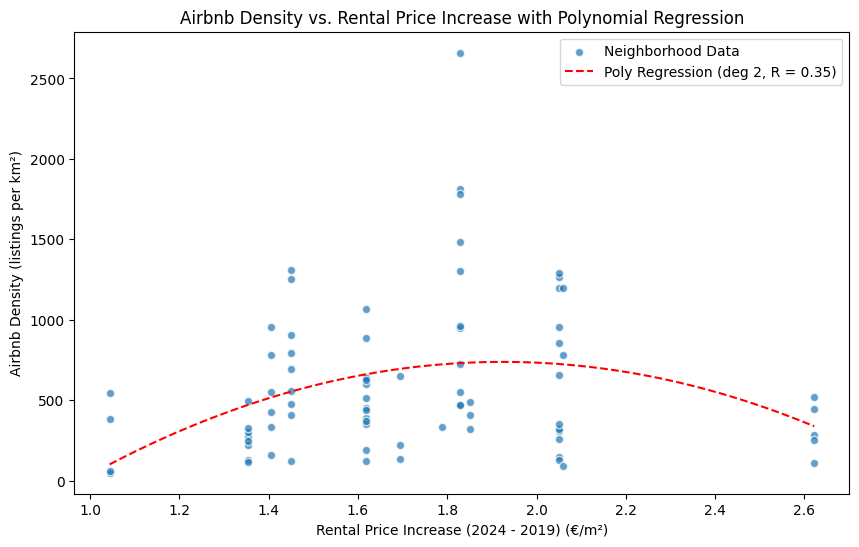

In [105]:
best_row = cv_results_df.loc[cv_results_df['test_mse'].idxmin()]
best_deg = int(best_row['degree'])
print(f"Best Polynomial Degree: {best_deg}")

poly_best = PolynomialFeatures(degree=best_deg, include_bias=False)
X_poly_best = poly_best.fit_transform(X)
lr_best = LinearRegression()
lr_best.fit(X_poly_best, Y)
r2_best = lr_best.score(X_poly_best, Y)
# Here R is approximated as sqrt(R²) (if the relationship is positive)
r_best = np.sqrt(r2_best) if r2_best >= 0 else 0

X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_range_poly = poly_best.transform(X_range)
Y_pred = lr_best.predict(X_range_poly)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X, Y, alpha=0.7, edgecolors='w', label='Neighborhood Data')
ax.plot(X_range, Y_pred, color='red', linestyle='--', 
        label=f'Poly Regression (deg {best_deg}, R = {r_best:.2f})')
ax.set_xlabel("Rental Price Increase (2024 - 2019) (€/m²)")
ax.set_ylabel("Airbnb Density (listings per km²)")
ax.set_title("Airbnb Density vs. Rental Price Increase with Polynomial Regression")
ax.legend()
plt.show()

# =============================================================================
# STEP 7: Plot 3 - Box Plot: Airbnb Density by Binned Rental Price Increase
# =============================================================================

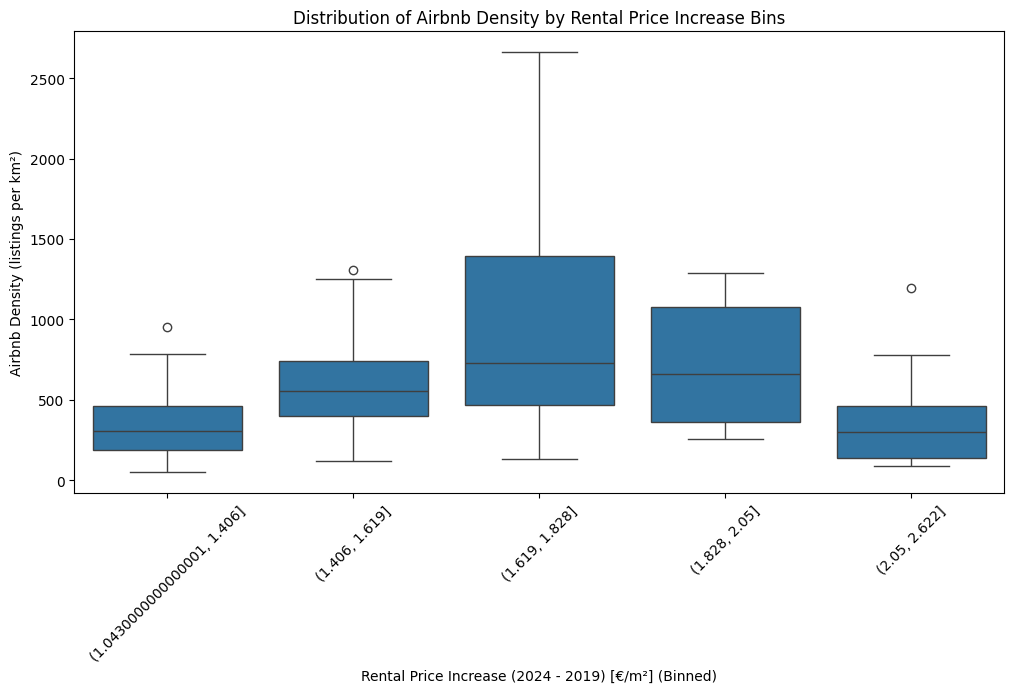

In [106]:
num_bins = 5
gdf_neigh['price_increase_bin'] = pd.qcut(gdf_neigh['price_increase'], q=num_bins, duplicates='drop')

plt.figure(figsize=(12, 6))
sns.boxplot(x='price_increase_bin', y='airbnb_density', data=gdf_neigh)
plt.xlabel("Rental Price Increase (2024 - 2019) [€/m²] (Binned)")
plt.ylabel("Airbnb Density (listings per km²)")
plt.title("Distribution of Airbnb Density by Rental Price Increase Bins")
plt.xticks(rotation=45)
plt.show()

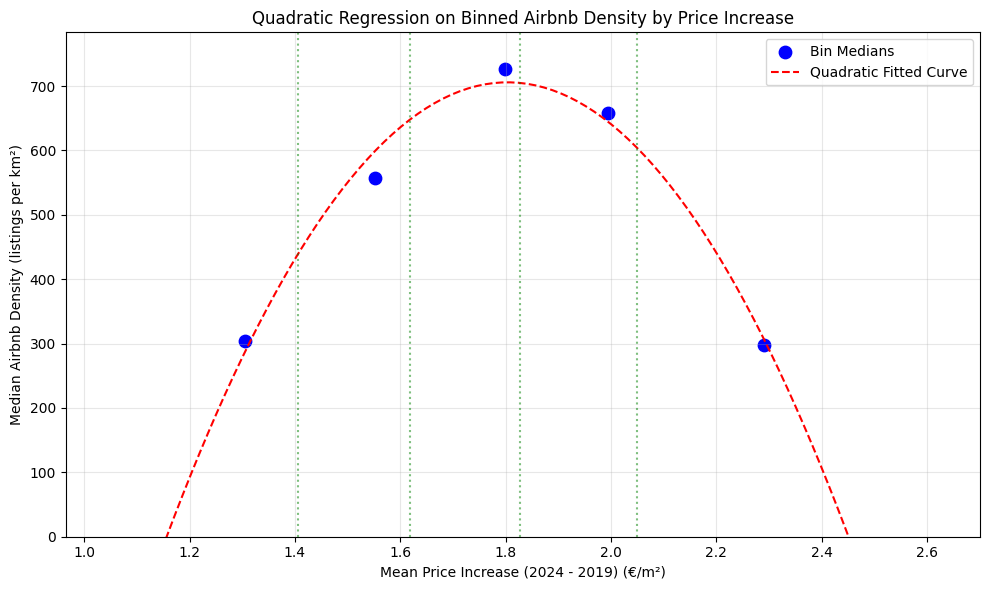

In [119]:
# Calculate the median airbnb density and mean price increase for each bin
bin_stats = gdf_neigh.groupby('price_increase_bin', observed = False).agg({
    'price_increase': 'mean', 
    'airbnb_density': 'median'
}).reset_index()

# Extract values for modeling
X_bin_means = bin_stats['price_increase'].values.reshape(-1, 1)
y_bin_medians = bin_stats['airbnb_density'].values

# Fit a 2nd degree polynomial regression
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = polynomial_features.fit_transform(X_bin_means)
model = LinearRegression()
model.fit(X_poly, y_bin_medians)

# Generate prediction curve points
X_curve = np.linspace(gdf_neigh['price_increase'].min(), gdf_neigh['price_increase'].max(), 100).reshape(-1, 1)
y_curve_pred = model.predict(polynomial_features.transform(X_curve))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bin statistics and fitted curve
ax.scatter(X_bin_means, y_bin_medians, color='blue', s=80, label='Bin Medians')
ax.plot(X_curve, y_curve_pred, color='red', linestyle='--', label='Quadratic Fitted Curve')

# Add bin edge vertical lines
bin_edges = pd.unique(gdf_neigh['price_increase_bin'].cat.categories.right.values[:-1])
for edge in bin_edges:
    ax.axvline(x=edge, color='green', linestyle=':', alpha=0.5)

# Set labels and style
ax.set_xlabel("Mean Price Increase (2024 - 2019) (€/m²)")
ax.set_ylabel("Median Airbnb Density (listings per km²)")
ax.set_title("Quadratic Regression on Binned Airbnb Density by Price Increase")
ax.legend()
ax.set_ylim(bottom=0)
ax.grid(True, alpha=0.3)

# Improve layout and display
plt.tight_layout()
plt.show()